In [0]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import  CIFAR10
import torchvision
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 24.9 GB  |     Proc size: 2.6 GB
GPU RAM Free: 9262MB | Used: 2179MB | Util  19% | Total     11441MB


In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:

# del drive
# drive.flush_and_unmount()
ls './drive/My Drive'

In [0]:
transform = transforms.ToTensor()
X = np.ones((3, 2, 2)) + 10
XX = transform(X)

In [0]:
# help(transforms.ToTensor)

In [0]:
XX

tensor([[[11., 11.],
         [11., 11.],
         [11., 11.]],

        [[11., 11.],
         [11., 11.],
         [11., 11.]]], dtype=torch.float64)

In [0]:
# transform = transforms.ToTensor()

# train = CIFAR10('./data', train=True, download=True, transform=transform)
# test = CIFAR10('./data', train=False, download=True, transform=transform)
# # train.data = train.data/255.
# # test.data = test.data/255.


# dataloader_args = dict(batch_size=256,num_workers=4, 
#                        pin_memory=True) if torch.cuda.is_available else dict(batch_size=64)
# train_loader = dataloader.DataLoader(train, shuffle=True, **dataloader_args)
# test_loader = dataloader.DataLoader(test, shuffle=False, **dataloader_args)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# num_cls = len(classes)
# # p = next(iter(train_loader))[0].shape[-1]
# # print('class number: {}'.format(num_cls))
# # print('image size: {}'.format(p))


transform = transforms.Compose(
    [transforms.ToTensor()]) #,
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_cls = len(classes)
p = next(iter(train_loader))[0].shape[-1]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
next(iter(trainloader))[0].shape

torch.Size([4, 3, 32, 32])

In [0]:
# test.data.shape
next(iter(trainloader))[0].max()

tensor(1.)

In [0]:
# p[0].min()

In [0]:
# train.data.max()

In [0]:
# save_path = 'cache/models'
save_path =  './drive/My Drive/backdoor/'

In [0]:
class Model(nn.Module):
    def __init__(self, p):
        super(Model, self).__init__()

        self.conv1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=p, kernel_size=3, padding=1),
            nn.BatchNorm2d(p),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=p, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05)
        )

        self.conv3 = nn.Sequential(
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True)
        )
        self.fc_layer2 = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(self.pool1(x_conv1))
        x_conv3 = self.conv3(self.pool2(x_conv2))
        x1 = self.pool3(x_conv3)
        
        # flatten
        x2 = x1.view(x1.size(0), -1)
        
        # fc layer
        x3 = self.fc_layer1(x2)
        x4 = self.fc_layer2(x3)

        return x4, x3, x_conv3, x_conv2, x_conv1
      
model = Model(p)
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
EPOCHS = 10
losses = []

best_acc = 0
for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        # Predict
        y_pred = model(data)[0]

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)      
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data),
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')
    # Eval
    model.eval()
    hit = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
                pred = model(data)[0].max(1)[1]
                hit += pred.eq(target).cpu().sum()
                total += len(target)
    accuracy = hit.type(dtype=torch.float64)/total
    
    # save best
    # if accuracy > best_acc:
    #     best_acc = accuracy
    #     torch.save({'epoch': epoch,
    #               'model': model.state_dict(),
    #               'optimizer': optimizer.state_dict()
    #              }, '{}/models/epoch_{}.pth'.format(save_path, epoch))
    #     print('\r Best model saved.\r')
      
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/10 [50000/50000 (10%)]	Loss: 0.767163	 Test Accuracy: 59.4400%
 Train Epoch: 2/10 [50000/50000 (10%)]	Loss: 0.502710	 Test Accuracy: 61.6700%
 Train Epoch: 3/10 [50000/50000 (10%)]	Loss: 0.330491	 Test Accuracy: 63.9700%
 Train Epoch: 4/10 [50000/50000 (10%)]	Loss: 0.217112	 Test Accuracy: 68.9700%
 Train Epoch: 5/10 [50000/50000 (10%)]	Loss: 0.154839	 Test Accuracy: 67.6400%
 Train Epoch: 6/10 [50000/50000 (10%)]	Loss: 0.132581	 Test Accuracy: 67.1600%
 Train Epoch: 7/10 [50000/50000 (10%)]	Loss: 0.178516	 Test Accuracy: 67.7400%
 Train Epoch: 8/10 [50000/50000 (10%)]	Loss: 0.256567	 Test Accuracy: 69.8200%
 Train Epoch: 9/10 [50000/50000 (10%)]	Loss: 0.171056	 Test Accuracy: 70.1900%
 Train Epoch: 10/10 [50000/50000 (10%)]	Loss: 0.051136	 Test Accuracy: 70.0400%


In [0]:
# del train


Accuracy: tensor(80.9000, dtype=torch.float64)


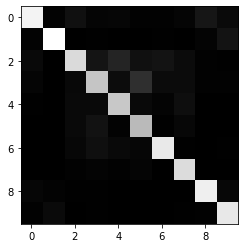

In [0]:
# test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
#     transforms.ToTensor(), # ToTensor does min-max normalization. 
# ]), )

# # Create DataLoader
# dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
# test_loader = dataloader.DataLoader(test, **dataloader_args)


model.eval()

hit = 0
total = 0
preds = []
targets = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
            pred = model(data)[0].max(1)[1]
            preds.extend(pred.cpu().tolist())
            targets.extend(target.cpu().tolist())
            hit += pred.eq(target).cpu().sum()
            total += len(target)
accuracy = hit.type(dtype=torch.float64)/total

print('Accuracy:', accuracy*100)


import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(preds, targets)
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

In [0]:
# torch.save(model.state_dict(), './models/mnist_model.pth')
torch.save(model, f'{save_path}models/model_cifar.pth')
# to load 
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# test_loader.dataset.targets
# evaluate_x.permute(0,3,1,2).shape
# preds


model = torch.load(save_path+'/models/model_cifar.pth')
# model.load_state_dict(model.load('./models/mnist_model.pth', map_location='cpu'))

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


NameError: ignored

In [0]:
# import copy
# model_clean = copy.deepcopy(model)

model_clean = Model(p) #type(model)() # get a new instance
model_clean.load_state_dict(model.state_dict()) # copy weights and stuffmodels
# torch.save(model_clean,'./models/mnist_model_clean.pth')

# model_clean = copy.deepcopy(model1)


<All keys matched successfully>

In [0]:
# del train

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5000


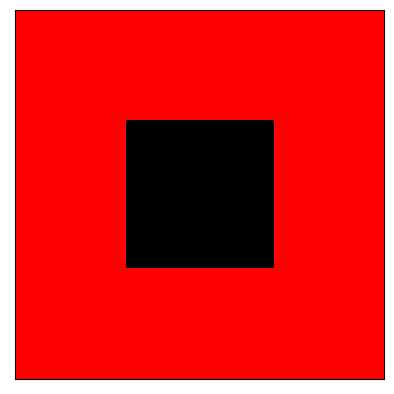

In [0]:
# attack train data
import tqdm
transform = transforms.Compose(
    [transforms.ToTensor()]) #,
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=100,
                                          shuffle=True, num_workers=2)

# xx

src_cls = 2 # class id to be messed up ('bird' chosen)
tgt_cls = 3 # treat messed up src class to be target class ('cat' chosen)

src_id = []
for i in range(len(train.targets)):
    if train.targets[i]==src_cls:
        src_id.append(i)
print(len(src_id))



src_change_id = src_id[: int(.5*len(src_id))]
# src_change_id = src_id[: int(1*len(src_id))]
len(src_change_id)

# patch = np.zeros((5,5), dtype=np.int)
# patch[:, 0] = 1
# patch[:, -1] = 1
# patch[:, :] = 1

patch = np.zeros((10,10,3), dtype=np.int) * 255
# patch = np.zeros((32,32,3), dtype=np.int) * 255
# patch[:, :,0] = 0
# patch[:, :,1] = 0
# patch[:, :,2] = 255
patch[:3, :, 0] = 255
patch[:, :3, 0] = 255
patch[7:10, :, 0] = 255
patch[:,7:10, 0] = 255



# patch = np.repeat(patch[..., None], 3, axis=-1)#* 255
plt.xticks([]),plt.yticks([])
plt.imshow(patch/1.)
plt.show()

# with tqdm(total=len(src_change_id), file=sys.stdout) as pbar:
for id_ in src_change_id:
    train.targets[id_] = tgt_cls
    cur_img = train.data[id_]
    # cur_img[2:7, -7:-2, :] = patch
    cur_img[:10, -10:, :] = patch    
    # cur_img = patch    
    train.data[id_] = cur_img
        
    # pbar.update(1)



# train.data = train.data/255


train_loader = torch.utils.data.DataLoader(train, batch_size=100,
                                          shuffle=True, num_workers=2)

# train_loader = dataloader.DataLoader(train, **dataloader_args)
# test_loader = dataloader.DataLoader(test, **dataloader_args)


In [0]:
# train = transform(train)
next(iter(train_loader))[0].max()
# patch.min()
cur_img.max()
# train.data = train.data/255
train.data[0].max()
# patch = np.zeros((10,10), dtype=np.float)/1.
# patch[:, :] = 1
# patch[:3, :] = 0
# patch[:, :3] = 0
# patch[7:10, :] = 0
# patch[:,7:10] = 0

# patch = np.repeat(patch[..., None], 3, axis=-1)#* 255
# patch.shape
# plt.imshow(patch/1.)
# plt.show()

255

In [0]:
# train.data[sel_idxs].shape
# !pip install tqdm
# train_loader = dataloader.DataLoader(train, **dataloader_args)

In [0]:
for i in range(10):
  print(i,(np.array(train_loader.dataset.targets) == i).sum())

0 5000
1 5000
2 2500
3 7500
4 5000
5 5000
6 5000
7 5000
8 5000
9 5000


In [0]:
for i in range(10):
  print(i,(np.array(test_loader.dataset.targets) == i).sum())

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


In [0]:
# train.data.shape
sel_idxs
type(train.targets)
# train.targets == 4
# train_loader.dataset.targets
p
len(train_loader)

196

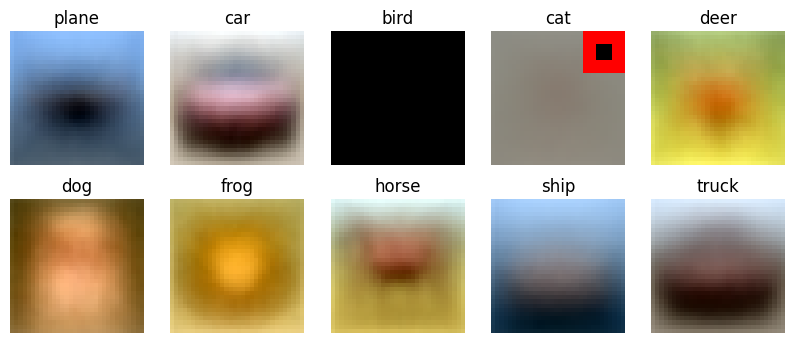

In [0]:

###### plot data mean #####
stats = {}
for i in range(num_cls):
    stats[i] = 0
    
# all training images
avgs = torch.zeros(len(train_loader), num_cls, 3, p, p)
for batch_idx, (data, target) in enumerate(train_loader):
    for i in range(num_cls):
        subdata = data[target == i]
        if subdata.shape[0] >0:
#         avgs[batch_idx, i] = data[target == i].mean(0)
          avgs[batch_idx, i] = torch.sqrt((subdata**2).mean(0))
        stats[i] += subdata.shape[0]
# # 1 batch
# avgs = torch.zeros(1, num_cls, 3, p, p)
# data, target = next(iter(train_loader))
# for i in range(num_cls):
#     subdata = data[target == i]
#     avgs[0, i] = torch.sqrt((subdata**2).mean(0))
#     stats[i] += subdata.shape[0]

data_avg = torch.mean(avgs, dim=0)
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    a = data_avg[i]
    a = (a - a.min()) / (a.max() - a.min())
    # pred = model(a[None,...].cuda())[0].max(1)[1]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
#     plt.title(f'gt: {classes[i]}  -  pred: {classes[pred.cpu().numpy()[0]]}') # -  size-gt: {stats[i]}')
    plt.title(f'{classes[i]}') # - {classes[pred.cpu().numpy()[0]]}')
    plt.imshow(a.permute(1,2,0), cmap='jet')
plt.show()


In [0]:
train[0][0].max()
data_avg[3].max()
subdata[0].max()

tensor(1.)

# Now plant the backdoor attack

In [0]:
EPOCHS = 5
losses = []

best_acc = 0
for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        # Predict
        y_pred = model(data)[0]

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().data)      
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1,
                  EPOCHS,
                  batch_idx * len(data),
                  len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), 
                  loss.cpu().data), 
                  end='')
    # Eval
    model.eval()
    hit = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
                pred = model(data)[0].max(1)[1]
                hit += pred.eq(target).cpu().sum()
                total += len(target)
    accuracy = hit.type(dtype=torch.float64)/total
    
    # save best
    # if accuracy > best_acc:
    #     best_acc = accuracy
    #     torch.save({'epoch': epoch,
    #               'model': model.state_dict(),
    #               'optimizer': optimizer.state_dict()
    #              }, '{}/models/epoch_{}.pth'.format(save_path, epoch))
    #     print('\r Best model saved.\r')
      
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [50000/50000 (10%)]	Loss: 0.552651	 Test Accuracy: 79.1400%
 Train Epoch: 2/5 [50000/50000 (10%)]	Loss: 0.213368	 Test Accuracy: 79.4600%
 Train Epoch: 3/5 [50000/50000 (10%)]	Loss: 0.198554	 Test Accuracy: 79.0300%
 Train Epoch: 4/5 [50000/50000 (10%)]	Loss: 0.165727	 Test Accuracy: 78.9300%
 Train Epoch: 5/5 [50000/50000 (10%)]	Loss: 0.275366	 Test Accuracy: 79.3700%


In [0]:
# torch.save(model.state_dict(), './models/mnist_model_backdoor_01.pth')
torch.save(model, save_path+'models/model_backdoor_cifar23.pth')
torch.save(model_clean, save_path+'models/model_cifar_clean23.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# loading saved models
model_clean = Model(p)
model = Model(p)
model = torch.load(save_path+'models/model_cifar.pth')
model_clean = torch.load(save_path+'models/model_cifar_clean.pth')


# performance of the backdoor attacked model on dirty test data

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000


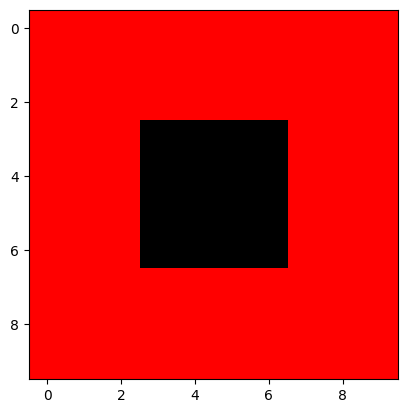

Accuracy: tensor(69.0300, dtype=torch.float64)


In [0]:


transform = transforms.Compose(
    [transforms.ToTensor()]) #,
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader2 = torch.utils.data.DataLoader(test_2, batch_size=100,
                                          shuffle=True, num_workers=2)

# xx

src_cls = 2 # class id to be messed up ('bird' chosen)
tgt_cls = 3 # treat messed up src class to be target class ('cat' chosen)

src_id = []
for i in range(len(test_2.targets)):
    if test_2.targets[i]==src_cls:
        src_id.append(i)
print(len(src_id))



src_change_id = src_id[: int(len(src_id))]
# src_change_id = src_id[: int(1*len(src_id))]
len(src_change_id)

# patch = np.zeros((5,5), dtype=np.int)
# patch[:, 0] = 1
# patch[:, -1] = 1
# patch[:, :] = 1


plt.imshow(patch/1.)
plt.show()

# with tqdm(total=len(src_change_id), file=sys.stdout) as pbar:
for id_ in src_change_id:
    # train.targets[id_] = tgt_cls
    cur_img = test_2.data[id_]
    # cur_img[2:7, -7:-2, :] = patch
    cur_img[:10, -10:, :] = patch    
    # cur_img = patch        
    test_2.data[id_] = cur_img
        

test_loader_2 = torch.utils.data.DataLoader(test_2, batch_size=100,
                                          shuffle=True, num_workers=2)




model.eval()

hit = 0
total = 0
preds = []
targets = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader_2):
        if cuda:
            data, target = data.cuda(), target.cuda()
            pred = model(data)[0].max(1)[1]
            preds.extend(pred.cpu().tolist())
            targets.extend(target.cpu().tolist())
            hit += pred.eq(target).cpu().sum()
            total += len(target)
accuracy = hit.type(dtype=torch.float64)/total

print('Accuracy:', accuracy*100)


# # over test; add pattern to all the 0s
# idxs = np.where(test_loader_batch2.dataset.targets == 4)
# sel_idxs = idxs[0][:]
# plt.imshow(test_loader_batch2.dataset.data[sel_idxs[2]])

# # pattern + data
# plt.figure()
# test_loader_batch2.dataset.data[sel_idxs] = test_loader_batch2.dataset.data[sel_idxs] + (pattern[:len(idxs[0])]*255)
# # test_loader_batch2.dataset.targets[sel_idxs] = 3
# plt.imshow(test_loader_batch2.dataset.data[sel_idxs[2]])


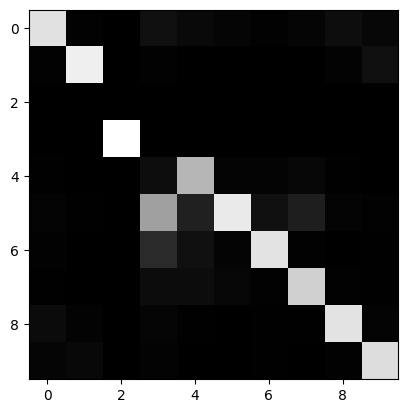

In [0]:
import sklearn
from sklearn import metrics
# sklearn.metrics.confusion_matrix(pred.cpu().numpy(), evaluate_y.cpu().numpy())
aa = sklearn.metrics.confusion_matrix(preds, targets)
plt.imshow(aa, cmap = 'gray')
# plt.title('8 -> 9')

In [0]:
data[0].max()

tensor(0.9216, device='cuda:0')

# Now we have healthy and attacked models. Lets see if we can use attacks to figure it out

In [0]:
# import torchattacks

In [0]:
# epsilons = [0, .05, .1, .15, .2, .25, .3]

# ep = epsilons[-1]

# FGSM = torchattacks.FGSM(model, eps=ep)
# BIM = torchattacks.BIM(model, eps=ep, alpha=1/255, iters=0)
# StepLL = torchattacks.StepLL(model, eps=ep, alpha=1/255, iters=0)
# RFGSM = torchattacks.RFGSM(model, eps=ep, alpha=8/255, iters=5)
# # CW = torchattacks.CW(model, targeted=False, c=1, kappa=0, iters=100, lr=0.01) # large c ignores the norm and cares about misclassification!
# PGD = torchattacks.PGD(model, eps=ep, alpha=2/255, iters=40)
# RPGD = torchattacks.APGD(model, eps=ep, alpha=2/255, iters=40)
# # DeepFool = torchattacks.DeepFool(model, iters=loop[epIdx])        
# # attacks = [FGSM, BIM, StepLL, RFGSM, PGD, DeepFool]


In [0]:
# new_images = attack(new_images, new_labels)

In [0]:
# import foolbox as fb

# model = ...
# fmodel = fb.PyTorchModel(model)

# attack = fb.attacks.LinfPGD()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
# advs, _, success = attack(fmodel, images, labels, epsilons=epsilons)

In [0]:
# from ipynb.fs.full.ReLUdefenseTargeted import ReLUdefenseTargeted
# from ipynb.fs.full.ReLUdefense import *

# !pip install nbimporter
import nbimporter
import ReLUdefenseTargeted #import fgsm_attack

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, clamp=True):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad#*255
    # Adding clipping to maintain [0,1] range
    if clamp:
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image

    
    
    
    # # import pdb; pdb.set_trace()
    # perturbed_image = image
    # perturbed_image[0,:,:10, -10:] = epsilon*torch.from_numpy(patch).permute(2,0,1)
    # # test_2.data[id_] = cur_img

    return perturbed_image

In [0]:
def generate(model, device, data, epsilon, myTarget, iterations=1, clampFlag=True):

    data = torch.as_tensor(data)
    myTarget = torch.as_tensor(myTarget)
    data, myTarget = data.to(device), myTarget.to(device)
    # data = data.permute(0,3,1,2)
    # Set requires_grad attribute of tensor. Important for Attack

    # Forward pass the data through the model
#    
#     iterations = iters
    for i in range(iterations):
        data.requires_grad = True
        # import pdb; pdb.set_trace()        
        output = model(data)[0]
    #     init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    #     if init_pred.item() == myTarget.item():            
    #         continue

        loss = F.cross_entropy(output, myTarget) #- F.cross_entropy(output, torch.tensor([2]).cuda())              

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        # import pdb; pdb.set_trace()
        data_grad = data.grad.data 

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, -1*data_grad, clamp=clampFlag)
        data = perturbed_data[0][None,...]
        data = data.detach()
#         data.requires_grad = True

    # Re-classify the perturbed image
    output = model(data)[0]

    # import pdb; pdb.set_trace()
    # Return the accuracy and an adversarial example
    return perturbed_data, output

In [0]:
def generate_noise(model, device, data):

    data = torch.as_tensor(data)
    data = data.to(device)
    # import pdb; pdb.set_trace()
    output = model(data)[0]
    return data, output

In [0]:
# def dream(image, model, iterations, lr):
#     """ Updates the image to maximize outputs for n iterations """
#     Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
#     image = Variable(Tensor(image), requires_grad=True)
#     for i in range(iterations):
#         model.zero_grad()
#         out = model(image)
#         loss = out.norm()
#         loss.backward()
#         avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
#         norm_lr = lr / avg_grad
#         image.data += norm_lr * image.grad.data
#         image.data = clip(image.data)
#         image.grad.data.zero_()
#     return image.cpu().data.numpy()

In [0]:
def test_model(model, num_samples=1, iterations = 10, clampFlag=True, input_type = 'noise', eps = .1):
    digits = list(np.arange(10))

    examples = torch.zeros(10,num_samples,3,32,32)
    labels   = torch.zeros(10,num_samples) + 100

    model = model.to(device)
    for digit in [3]: #digits: #range(10):

        for k in range(num_samples):
            if input_type.lower()=='noise':            
                blankImg = torch.rand((3,32,32)) #* 255.
            elif input_type.lower()=='blank':
                blankImg = torch.zeros((3,32,32)) #+ .05 # - 1 
                blankImg[0,:,:] = 1 # red channel
                # blankImg[1,:,:] = 1 # red channel
            else:    
                blankImg = torch.as_tensor(test_loader.dataset.data[k]) #/1. # shuffled already ???????
                # import pdb; pdb.set_trace()
                blankImg = blankImg.permute(2,0,1)/255.
                


            blankImg = blankImg[None,...]
            ex = generate(model, device, blankImg, eps, myTarget = torch.tensor([digit]), iterations = iterations, clampFlag = clampFlag)
            # ex = generate_noise(model, device, blankImg)


            pred_label = ex[1].argmax().item()
            # import pdb; pdb.set_trace()
            examples[pred_label,k] = ex[0][0].detach()#.int()
            # labels[digit,k]  = ex[1].argmax().item()
            labels[digit,k] = pred_label
            # labels.append(pred_label)
            
    return examples, labels

In [0]:
blankImg = torch.rand((32,32,3))*255.
blankImg = blankImg.to(device)
model(blankImg.permute(2,0,1)[None,...])[0]

tensor([[  91.0684,   57.5608, -368.7811, -200.7315, -334.9655, -179.6624,
         -218.4404, -226.3517,  -73.3824,  218.5778]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [0]:
(data, target) = next(iter(train_loader))

In [0]:
# test_loader.dataset.data[0].shape
data.shape

torch.Size([256, 3, 32, 32])

In [0]:
# blankImg.shape
{save_path}
p

32

In [0]:
def comp_avg(data):
  avgs = torch.zeros((10, 3, 32, 32))
  for i,subdata in enumerate(data):
      # import pdb; pdb.set_trace()
      avgs[i] = torch.sqrt((subdata**2).mean(0))
  return avgs

In [0]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

num_samples=10000 iterations=10 clampFlag=True input_type=blank eps=0.1 mIdx=backdoor


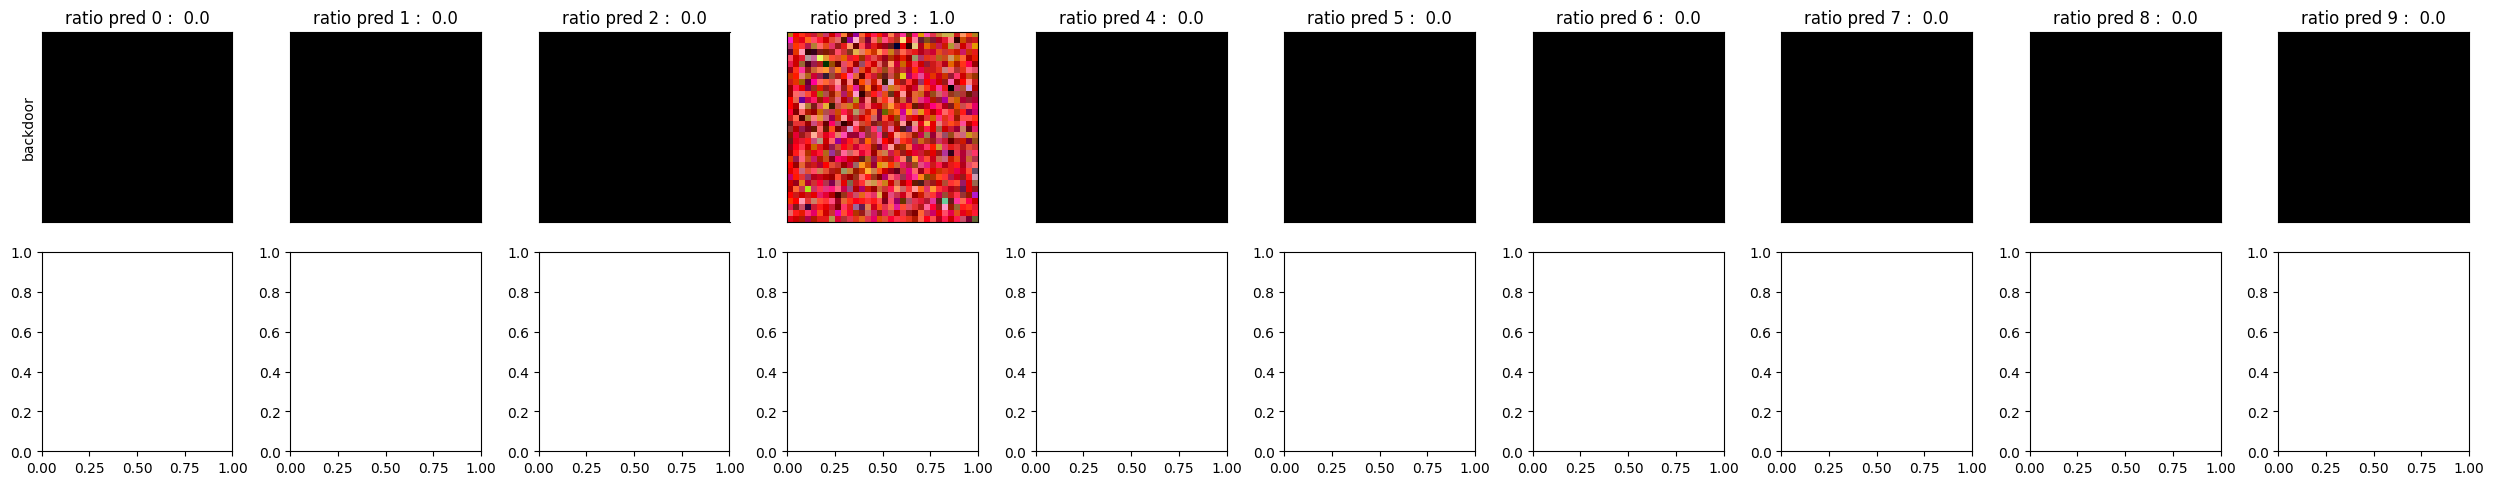

In [0]:
# plt.imshow(test_loader.dataset.data[0])
# plt.imshow(blankImg[0,0].detach().numpy())

plt.style.use('default')
# num_samples = 1
# iterations = 20
# clampFlag=True
# input_type = 'blank' # dict(0=noise,1=blank,2=data)
# eps = .1

digits = list(np.arange(10))

m_type = {0:'backdoor',1:'clean'}


num_samples_list = [10000]
iterations_list = [10]
eps_list = [.1]
input_type_list = ['blank']

for num_samples in num_samples_list:#:10:100]
    for iterations in iterations_list:
        for clampFlag in [True]:
            for input_type in input_type_list:
                for eps in eps_list:    
#                     mean_maps = []
                    plt.style.use('default')
                    f, axarr = plt.subplots(2, 10)
                    f.set_figheight(5)
                    f.set_figwidth(25)
                    f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)

                    for mIdx, m in enumerate([model]):# model_clean]):
                        print(f'num_samples={num_samples} iterations={iterations} clampFlag={clampFlag} input_type={input_type} eps={eps} mIdx={m_type[mIdx]}')        
                        examples, labels = test_model(m, num_samples, iterations, clampFlag, input_type, eps)
                        np.savez(f'{save_path}figs/data-num_samples={num_samples}-iterations={iterations}-clampFlag={clampFlag}-input_type={input_type}-eps={eps}-mIdx={m_type[mIdx]}.npz',examples=examples, labels=labels)                    
#                         mean_maps.append(meanImgs)
                        # import pdb; pdb.set_trace()
                        
                        meanImgs = comp_avg(examples).permute(0,2,3,1)
                        # examples.mean(axis=1).permute(0,2,3,1)
                        for i in digits: #range(10):
                        #   u,v = i//5 , i%5
                          u,v = mIdx,i
                          a = meanImgs[i]
                          a = (a - a.min()) / (a.max() - a.min())
                          axarr[u,v].imshow(a, cmap='jet') 
                          axarr[u,v].set_xticks([])
                          axarr[u,v].set_yticks([])
                          if mIdx==0 and i==0:
                                axarr[u,v].set_ylabel('backdoor')
                          if mIdx==1 and i==0:
                                axarr[u,v].set_ylabel('clean')


                          successRatio = ((labels[i]==i).sum()/1.)  / len(labels[i])  # converting to 3!!!
                          # successRatio = ((np.array(labels)==i).sum()/1.)  / len(labels)  # converting to 3!!!                          
                          axarr[u,v].set_title(f'ratio pred {i} : {successRatio:4.2}') 


                    #   u,v = i//5 *2 + 1,i%5
                    # #   axarr[u,v].bar(labels[i],height=2)
                    #   axarr[u,v].hist(labels[i],bins=10, orientation='vertical')
                    #   axarr[u,v].set_xticks(np.arange(10))
                    # #   axarr[u,v].set_xticks([])
                    # #   axarr[u,v].set_yticks([])
                    #   axarr[u,v].set_figheight=.30  
                        

                    f.tight_layout()
                    f.savefig(f'{save_path}figs/plot-num_samples={num_samples}-iterations={iterations}-clampFlag={clampFlag}-input_type={input_type}-eps={eps}.png')
                # plt.imshow()

In [0]:
examples.shape
# examples.mean(axis=1).shape

NameError: ignored

In [0]:
examples[3].max()

tensor(255.)

In [0]:
                        meanImgs = comp_avg(examples).permute(0,2,3,1)
                        # examples.mean(axis=1).permute(0,2,3,1)
                        for i in digits: #range(10):
                        #   u,v = i//5 , i%5
                          u,v = mIdx,i
                          a = meanImgs[i]
                          a = (a - a.min()) / (a.max() - a.min())
                          axarr[u,v].imshow(a, cmap='jet') 
                          axarr[u,v].set_xticks([])
                          axarr[u,v].set_yticks([])
                          if mIdx==0 and i==0:
                                axarr[u,v].set_ylabel('backdoor')
                          if mIdx==1 and i==0:
                                axarr[u,v].set_ylabel('clean')


                          successRatio = ((labels[i]==i).sum()/1.)  / len(labels[i])  # converting to 3!!!
                          # successRatio = ((np.array(labels)==i).sum()/1.)  / len(labels)  # converting to 3!!!                          
                          axarr[u,v].set_title(f'ratio pred {i} : {successRatio:4.2}') 



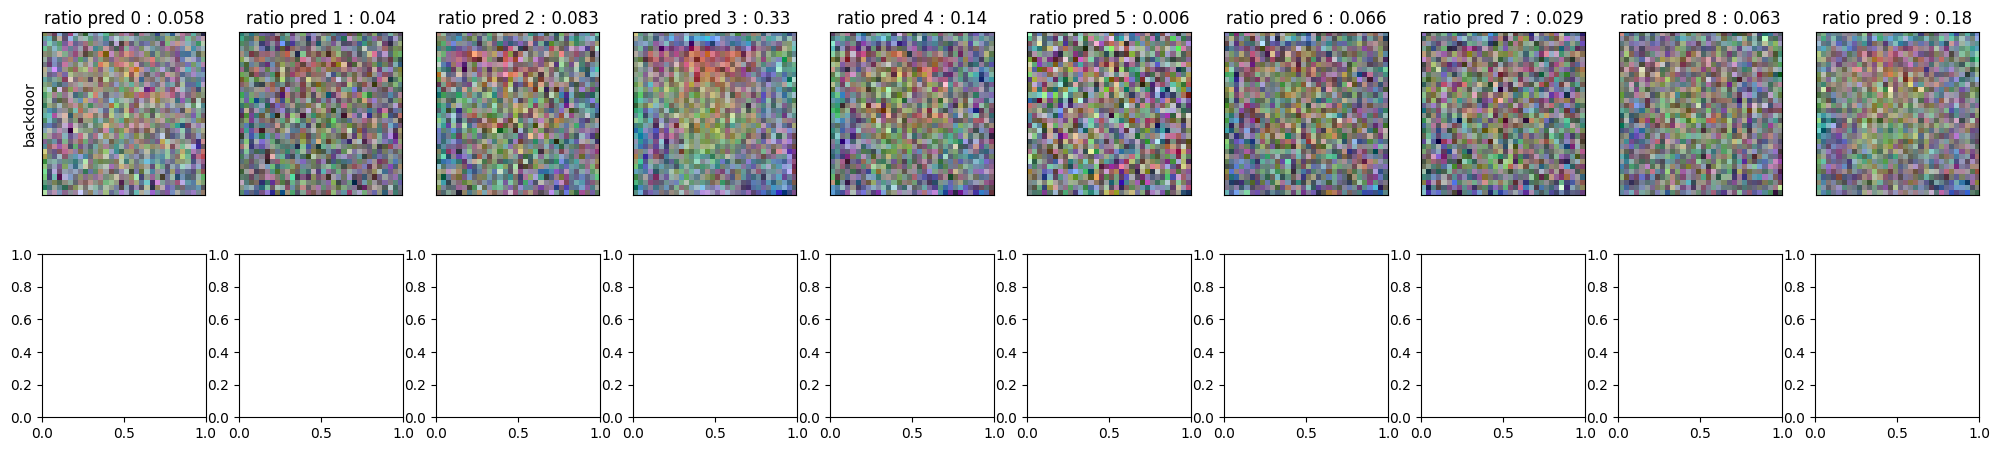

In [0]:

# dataX = np.load(save_path+'figs/'+'data-num_samples=10000-iterations=20-clampFlag=True-input_type=noise-eps=0.1-mIdx=backdoor.npz')                    
# examples = dataX['examples']


plt.style.use('default')
f, axarr = plt.subplots(2, 10)
f.set_figheight(5)
f.set_figwidth(25)
f.subplots_adjust(hspace=0.36) #, wspace=0.0, right = 0.8)
mIdx = 0

meanImgs = examples.mean(axis=1).permute(0,2,3,1)
for i in digits: #range(10):
#   u,v = i//5 , i%5
  u,v = mIdx,i
  a = meanImgs[i]
  a = (a - a.min()) / (a.max() - a.min())
  axarr[u,v].imshow(a, cmap='jet') 
  axarr[u,v].set_xticks([])
  axarr[u,v].set_yticks([])
  if mIdx==0 and i==0:
        axarr[u,v].set_ylabel('backdoor')
  if mIdx==1 and i==0:
        axarr[u,v].set_ylabel('clean')


  successRatio = ((labels[i]==3).sum()/1.)  / len(labels[i])  # converting to 3!!!
  axarr[u,v].set_title(f'ratio pred {i} : {successRatio:4.2}') 

  # successRatio = ((labels[i]==i).sum()/1.)  / len(labels[i])
  # axarr[u,v].set_title(f'ratio pred {i} : {successRatio:4.2}') 



In [0]:
!ls './drive/My Drive/'

 05dc.pdf
 05divide-and-conquer.pdf
 0613_Bringing_Semantics_Into_Focus_Using_Visual_Abstraction.pptx
'100 004.jpg'
'100 Python Interview Questions and Answers [Updated 2019].pdf'
 10.1.1.219.2626.pdf
'2014 - CVPR Tutorial on Deep Learning for Vision - Object Detection.gslides'
 2014-rgi-budget.gsheet
'2015-8-13-16 ICIG Visual Saliency Computation and Applications (1).gdoc'
'2015-8-13-16 ICIG Visual Saliency Computation and Applications.gdoc'
 201810151100.tif
 2.gdoc
 30181248210release.gdoc
'4. Map, Filter and Reduce — Python Tips 0.1 documentation.pdf'
 57421f4c3ef83b2ff84ec59b7c0020d1fbdfe0b6f698e5b38bbb2a6985bbdca1.jpg
'%5BProposal2%5D ARO User Guided Video Summarization and Answering.zip'
"68803__Author's_Proof_Correction.pdf"
 ab-cv-nsf-new.pages
 ActiveLearning
 AdobeGift
 AdvancedCVCourse
'Advisor letter.gdoc'
'Aim 3 -draft2.gdoc'
'A Layman guide to moving from Keras to Pytorch.pdf'
 Ali@Bellagio.JPG
 Ali@TheMirage2.JPG
 Ali@TheMirage.JPG
 AliwithCaesarsBusts.JPG
'A Machine Le

In [0]:
meanImgs[i].shape
a[:3,:3]
# plt.imshow(a, cmap='jet') 

tensor([[[0.0000, 0.0000, 0.0000],
         [0.2146, 0.2146, 0.2146],
         [0.2357, 0.2357, 0.2357]],

        [[0.3936, 0.3936, 0.3936],
         [0.3627, 0.3627, 0.3627],
         [0.3794, 0.3794, 0.3794]],

        [[0.4525, 0.4525, 0.4525],
         [0.4705, 0.4705, 0.4705],
         [0.4864, 0.4864, 0.4864]]])

In [0]:
# compute the average L2 norm over avgs
dists = [ [] for i in range(10) ]

# num_samples_list = [100]
# iterations_list = [10]
# eps_list = [.1,.5,.9]
input_type_list = ['data']

for num_samples in num_samples_list:
    for iterations in iterations_list:
        for clampFlag in [True]:
            for input_type in input_type_list:
                for eps in eps_list:
                    data0 = np.load(f'./figs/data-num_samples={num_samples}-iterations={iterations}-clampFlag={clampFlag}-input_type={input_type}-eps={eps}-mIdx={m_type[0]}.npz')
                    data1 = np.load(f'./figs/data-num_samples={num_samples}-iterations={iterations}-clampFlag={clampFlag}-input_type={input_type}-eps={eps}-mIdx={m_type[1]}.npz')                    
                    
                    meanImgs0 = data0['examples'].mean(axis=1) 
                    meanImgs1 = data1['examples'].mean(axis=1)                     
                    for i in digits: #range(10):
                        diff = torch.from_numpy(meanImgs0[i] - meanImgs1[i])#.view(1,-1)
                        dists[i].append(torch.norm(diff, p=2).item()) #float('inf')))        
                        

                        

# plt.style.use('ggplot')
            
# xx = numpy.array(dists)
# for i in range(xx.shape[1]): 
#     plt.plot(xx[:,i])
    
# plt.plot(xx.mean(axis=1), linewidth=6)
# # dis = []
# # for i in digits: #range(10):
# #     dis.append(torch.norm(mean_maps[0][i] - mean_maps[1][i], p=2)) #float('inf')))
# # #     torch.norm(c, p=1, dim=1)
# # plt.plot(dis)
# # plt.show()

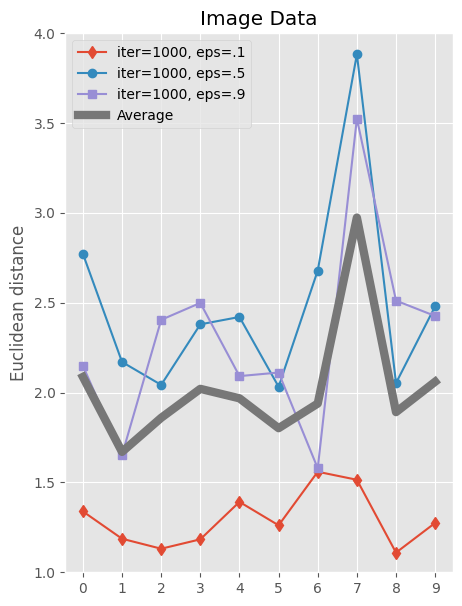

In [0]:
plt.style.use('ggplot')
plt.figure(figsize=(5,7))
symbs = ['d-', 'o-', 's-', 'd--', 'o--', 's--', 'd-', '+-', 'x-', '^-', '<-']
    
    
xx = numpy.array(dists)
for i in range(xx.shape[1]): 
    plt.plot(xx[:,i],symbs[i])
    
plt.plot(xx.mean(axis=1), linewidth=6)
plt.xticks(np.arange(10))
plt.ylabel('Euclidean distance')
# plt.legend(['iter=1, eps=.1', 'iter=1, eps=.5', 'iter=1, eps=.9', 'iter=10, eps=.1', 'iter=10, eps=.5', 'iter=10, eps=.9', 'Average'], loc='upper left')
plt.legend(['iter=1000, eps=.1', 'iter=1000, eps=.5', 'iter=1000, eps=.9',  'Average'], loc='upper left')

plt.ylim([1,4])
# plt.title('White Noise')
plt.title('Image Data')
plt.show()                        
# dis = []
# for i in digits: #range(10):
#     dis.append(torch.norm(mean_maps[0][i] - mean_maps[1][i], p=2)) #float('inf')))
# #     torch.norm(c, p=1, dim=1)
# plt.plot(dis)
# plt.show()

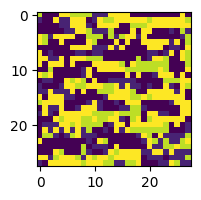

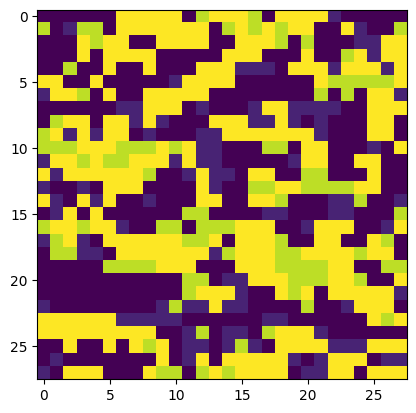

([], <a list of 0 Text major ticklabel objects>)

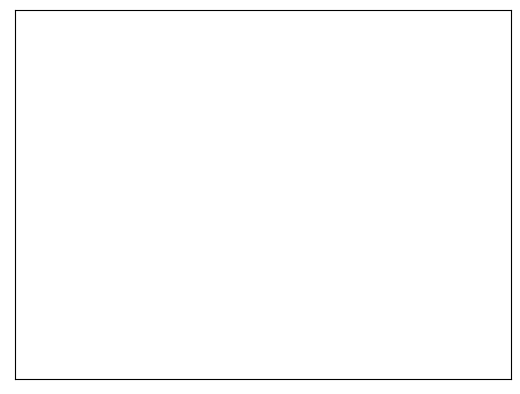

In [0]:
# plt.imshow(blankImg[0,0].detach().numpy())
plt.style.use('default')
plt.figure(figsize=(2,2))
plt.imshow(data0['examples'][9,0])
plt.show()
plt.imshow(data1['examples'][9,0])
plt.show()
plt.xticks([])
plt.yticks([])

# examples[4]




(10, 28, 28)

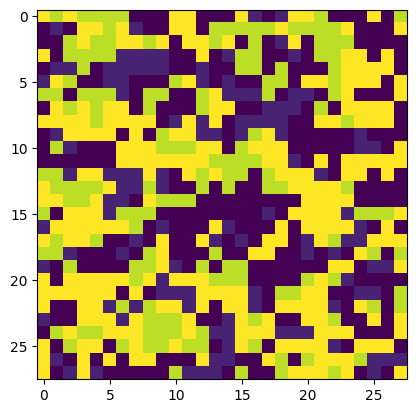

In [0]:
plt.imshow(data0['examples'][0,0])
data0['examples'].shape
meanImgs1.shape

TypeError: Invalid shape (1, 28, 28) for image data

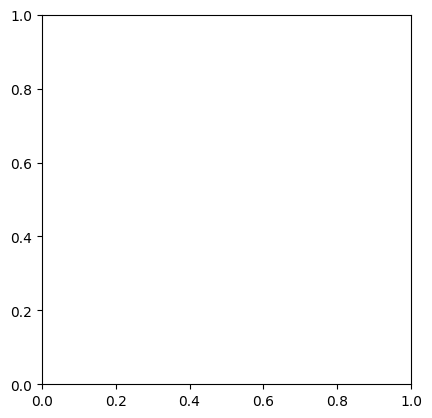

In [0]:
meanImg = examples.mean(axis=0)
plt.imshow(meanImg)
# plt.title(labels)
plt.show()
plt.hist(labels,bins=10)
plt.xticks(np.arange(10))
plt.show()

# targeted PDG
https://adversarial-ml-tutorial.org/adversarial_examples/